In [1]:
from annoy import AnnoyIndex
import random
from sklearn.neighbors import NearestNeighbors
# from Annoy import Annoy
from CppAnnoy.IterAnnoy import PyAnnoy
import time
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def recall(y_true, y_pred):
    common = [i for i in y_pred if i in y_true]
    return len(common)/len(y_true)

# Time

In [3]:
annoy_init_time = []
ball_init_time = []
kd_init_time = []
brute_init_time = []
my_annoy_init_time = []
my_parallel_annoy_init_time = []

annoy_query_time = []
ball_query_time = []
kd_query_time = []
brute_query_time = []
my_annoy_query_time = []
my_parallel_annoy_query_time = []

dimensions = [16, 32 ,64 ,128 ,512 , 1024]
repeats = 100 # number of queries to sum
distances = False
k = 10
n_trees = 30
n_samples = 5000


for d in dimensions:
    print(d)
    samples = np.random.random((n_samples, d)).astype('float32')
    query = np.random.random((1, d)).astype('float32')
    start_time = time.time()
    t = AnnoyIndex(d, 'euclidean')  # Length of item vector that will be indexed
    for i, v in enumerate(samples):
        t.add_item(i, v)
    t.build(n_trees)  # 10 trees
    annoy_init_time.append(time.time()-start_time)

    start_time = time.time()
    for _ in range(repeats):
        annoy_ret = t.get_nns_by_vector(query[0], k, include_distances=distances)
    annoy_query_time.append(time.time()-start_time)

    start_time = time.time()
    neigh = NearestNeighbors(n_neighbors=k, radius=0.4, algorithm='ball_tree', metric='euclidean', n_jobs=-1)
    neigh.fit(samples)
    ball_init_time.append(time.time()-start_time)

    start_time = time.time()
    for _ in range(repeats):
        ball_tree_ret = neigh.kneighbors(query, k, return_distance=distances)[0]
    ball_query_time.append(time.time()-start_time)

    start_time = time.time()
    neigh = NearestNeighbors(n_neighbors=k, algorithm='kd_tree', metric='euclidean', n_jobs=-1)
    neigh.fit(samples)
    kd_init_time.append(time.time()-start_time)

    start_time = time.time()
    for _ in range(repeats):
        kd_tree_ret = neigh.kneighbors(query, k, return_distance=distances)[0]
    kd_query_time.append(time.time()-start_time)

    start_time = time.time()
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean', n_jobs=-1)
    neigh.fit(samples)
    brute_init_time.append(time.time()-start_time)

    start_time = time.time()
    for _ in range(repeats):
        brute_ret = neigh.kneighbors(query, k, return_distance=distances)[0]
    brute_query_time.append(time.time()-start_time)

    start_time = time.time()
    my_annoy = PyAnnoy(samples, leaf_size=40, n_trees=n_trees)
    my_annoy.build_tree()
    my_annoy_init_time.append(time.time()-start_time)
    sys.stdout.flush()
    start_time = time.time()
    for _ in range(repeats):
        my_annoy_ret = my_annoy.query_tree(query[0], k)
    my_annoy_query_time.append(time.time()-start_time)


    start_time = time.time()
    my_annoy = PyAnnoy(samples, leaf_size=40, n_trees=n_trees, n_jobs=7)
    my_annoy.build_tree()
    my_parallel_annoy_init_time.append(time.time()-start_time)
    sys.stdout.flush()
    start_time = time.time()
    for _ in range(repeats):
        my_annoy_ret = my_annoy.query_tree(query[0], k)
    my_parallel_annoy_query_time.append(time.time()-start_time)

16
32
64
128
512
1024


In [4]:
print(my_annoy_ret)

[1166, 2825, 2825, 2825, 2825, 2825, 2825, 4754, 4754, 4754]


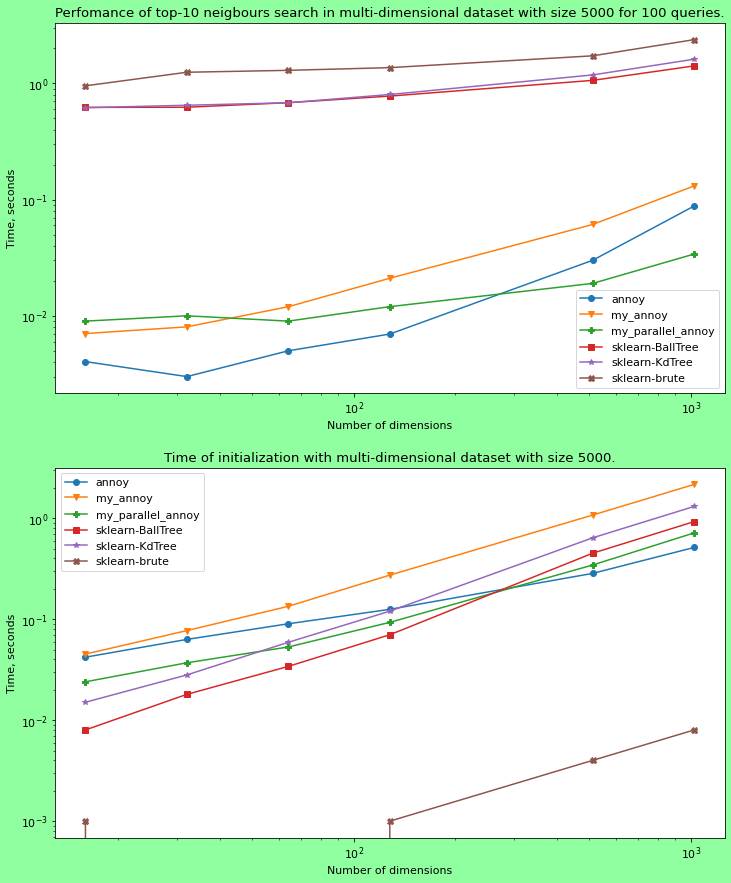

In [5]:
# from lev's code
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (12, 15)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:mint green')
ax = fig.add_subplot(2, 1, 1)
ax.plot(dimensions, annoy_query_time,marker='o')
ax.plot(dimensions, my_annoy_query_time,marker='v')
ax.plot(dimensions, my_parallel_annoy_query_time,marker='P')
ax.plot(dimensions, ball_query_time,marker='s')
ax.plot(dimensions, kd_query_time,marker='*')
ax.plot(dimensions, brute_query_time,marker='X')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(f'Perfomance of top-10 neigbours search in multi-dimensional dataset with size {n_samples} for {repeats} queries.')
plt.legend(["annoy", "my_annoy", "my_parallel_annoy", "sklearn-BallTree", "sklearn-KdTree", "sklearn-brute"])
plt.xlabel("Number of dimensions", )
plt.ylabel("Time, seconds")

ax = fig.add_subplot(2, 1, 2)
ax.plot(dimensions, annoy_init_time,marker='o')
ax.plot(dimensions, my_annoy_init_time,marker='v')
ax.plot(dimensions, my_parallel_annoy_init_time,marker='P')
ax.plot(dimensions, ball_init_time,marker='s')
ax.plot(dimensions, kd_init_time,marker='*')
ax.plot(dimensions, brute_init_time,marker='X')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title(f'Time of initialization with multi-dimensional dataset with size {n_samples}.')
plt.legend(["annoy", "my_annoy", "my_parallel_annoy", "sklearn-BallTree", "sklearn-KdTree", "sklearn-brute"])
plt.xlabel("Number of dimensions", )
plt.ylabel("Time, seconds")
plt.show()

# Recall

In [ ]:
Ks = [1, 5, 10, 100]
dimensions = [16, 32 ,64, 128]
n_trees_list = [1, 10, 30, 50, 100]
repeats = 10 # number of queries to sum
distances = False
leaf_size = 30
n_jobs = 6
n_samples = 5000

annoy_query_recall = []
my_annoy_query_recall = []

for i, k in enumerate(Ks):
    print(f'{k=}')
    annoy_query_recall.append([])
    my_annoy_query_recall.append([])

    for j, d in enumerate(dimensions):
        print(f'\t{d=}')
        annoy_query_recall[i].append([])
        my_annoy_query_recall[i].append([])

        for n_trees in n_trees_list:
            print(f'\t\t{n_trees=}')
            annoy_query_recall[i][j].append(0)
            my_annoy_query_recall[i][j].append(0)

            samples = np.random.random((n_samples, d)).astype('float32')

            neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean', n_jobs=-1)
            neigh.fit(samples)

            dev = 0
            for _ in range(repeats):
                t = AnnoyIndex(d, 'euclidean')  # Length of item vector that will be indexed
                for idx, v in enumerate(samples):
                    t.add_item(idx, v)
                t.build(n_trees)  # 10 trees

                my_annoy = PyAnnoy(samples, leaf_size=leaf_size, n_trees=n_trees, n_jobs=n_jobs)
                my_annoy.build_tree()

                for _ in range(repeats):
                    query = np.random.random((1, d)).astype('float32')
                    brute_ret = neigh.kneighbors(query, k, return_distance=distances)[0]
                    annoy_ret = t.get_nns_by_vector(query[0], k, include_distances=distances)
                    my_annoy_ret = my_annoy.query_tree(query[0], k)
                    if my_annoy_ret is not None:
                        dev += 1
                        my_annoy_query_recall[i][j][-1] += recall(brute_ret, my_annoy_ret)
                    annoy_query_recall[i][j][-1] += recall(brute_ret, annoy_ret)

            annoy_query_recall[i][j][-1] /= dev
            my_annoy_query_recall[i][j][-1] /= dev
print('done')

k=1
	d=16
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=32
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=64
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=128
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
k=5
	d=16
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=32
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=64
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50
		n_trees=100
	d=128
		n_trees=1
		n_trees=10
		n_trees=30
		n_trees=50


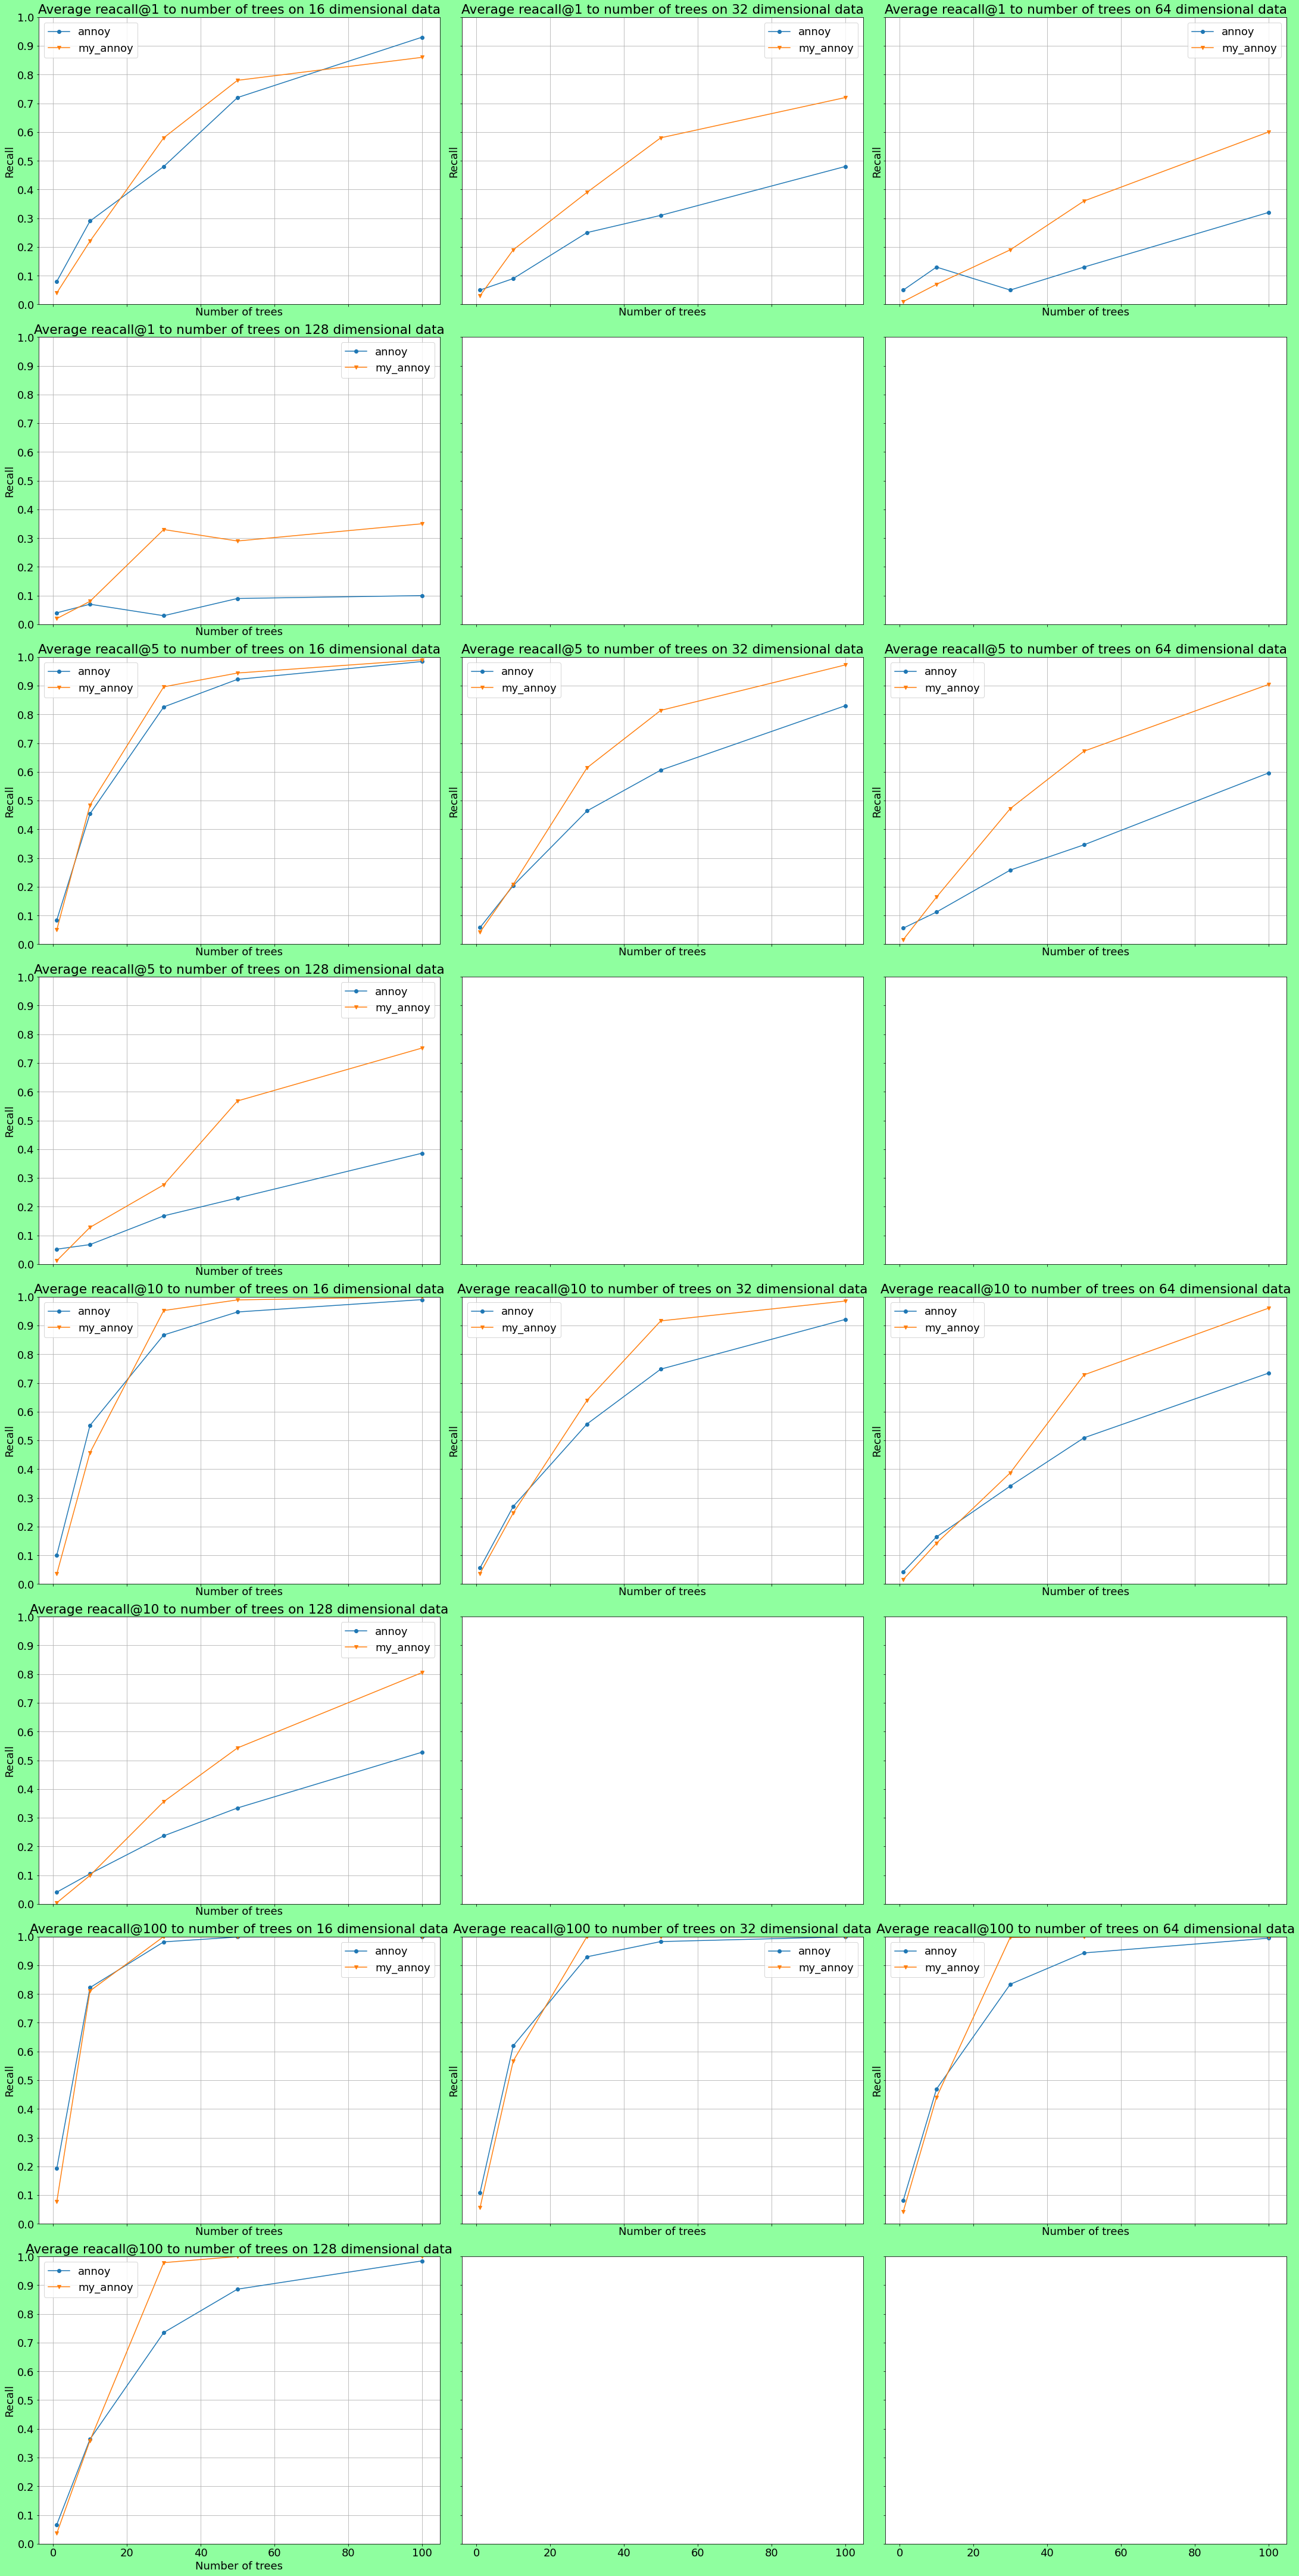

In [7]:
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(len(Ks)*( (2 + len(dimensions)) // 3), 3, figsize=(30, 60), constrained_layout=True,
                        sharex=True, sharey=True)
fig.patch.set_facecolor('xkcd:mint green')

for i in range(len(Ks)):
    for j in range(len(dimensions)):
        ax = axs[i * (1+len(dimensions)//3) + j//3][j%3]
        major_ticks = np.linspace(0, 1, 11)
        ax.set_yticks(major_ticks)
        ax.grid(True)
        ax.plot(n_trees_list, annoy_query_recall[i][j], marker='o')
        ax.plot(n_trees_list, my_annoy_query_recall[i][j], marker='v')
        ax.title.set_text(f'Average reacall@{Ks[i]} to number of trees on {dimensions[j]} dimensional data')
        ax.legend([f'annoy', "my_annoy"])
        ax.set_xlabel('Number of trees')
        ax.set_ylabel('Recall')
        ax.set_ylim([0, 1])
plt.show()